In [1]:
import tidy3d as td
import numpy as np
import tidy3d.web as web

import matplotlib.pyplot as plt

In [2]:
freq0 = td.C_0/1.5
fwidth = 0.1*freq0

Vacuum = td.Medium(
    name = 'Vacuum', 
)

planewave_0 = td.PlaneWave(
    name = 'planewave_0', 
    size = [td.inf, td.inf, 0], 
    source_time = td.GaussianPulse(freq0 =freq0, fwidth = fwidth, ), 
    direction = '+', 
)

diffractionmonitor_0 = td.DiffractionMonitor(
    name = 'DT', 
    center = [0, 0, 1], 
    size = [td.inf, td.inf, 0], 
    freqs = [freq0], 
    normal_dir='-',
)

diffractionmonitor_0_Copy = td.DiffractionMonitor(
    name = 'DR', 
    center = [0, 0, -1], 
    size = [td.inf, td.inf, 0], 
    freqs = [freq0], 
    normal_dir = '-'
)

fluxMonT = td.FluxMonitor(
    name = 'FT', 
    center = [0, 0, 0.5], 
    size = [td.inf, td.inf, 0], 
    freqs = [freq0], 
)

fluxMonR = td.FluxMonitor(
    name = 'FR', 
    center = [0, 0, -0.5], 
    size = [td.inf, td.inf, 0], 
    freqs = [freq0], 
    normal_dir = '-'
)



fieldMom = td.FieldMonitor(center = (0,0,0),
                           size = (0,td.inf,td.inf),
                           freqs = [freq0],
                           name = 'fieldMon',
                           )
sim = td.Simulation(
    size = [1, 1, 7], 
    boundary_spec = td.BoundarySpec(x = td.Boundary(plus = td.BlochBoundary(bloch_vec = 0), minus = td.BlochBoundary(bloch_vec = 0), ), y = td.Boundary(plus = td.BlochBoundary(bloch_vec = 0), minus = td.BlochBoundary(bloch_vec = 0), ), z = td.Boundary(plus = td.Absorber(num_layers=80), ), ), 
    grid_spec = td.GridSpec.auto(wavelength = 1.55, min_steps_per_wvl = 15), 
    run_time = 2.5851216749408594e-12,
    medium = Vacuum,
    sources = [planewave_0],
    monitors = [diffractionmonitor_0,diffractionmonitor_0_Copy,fieldMom,fluxMonT,fluxMonR],
    structures = [],
)


In [3]:
box = td.Box.from_bounds(rmin = [-99,-99,-99],rmax = [99,99,2]) 
structure = td.Structure(
    geometry = box, 
    medium= td.Medium(permittivity=3.5**2), 
)



def make_sim(theta,pol_angle = 0,norm = False):
    theta_rad = (np.pi/180)*theta
    pol_rad = (np.pi/180)*pol_angle

    planewave = td.PlaneWave(
        size = [td.inf, td.inf, 0], 
        source_time = td.GaussianPulse(freq0 = freq0, fwidth = fwidth), 
        direction = '+', 
        angle_theta=theta_rad,
        pol_angle=pol_rad
    )

    # Bloch boundaries.
    bloch_x = td.Boundary.bloch_from_source(
    source=planewave,
    domain_size=1,
    axis=0,
    medium=td.Medium(permittivity=3.5**2)
    )

    bloch_y = td.Boundary.bloch_from_source(
    source=planewave,
    domain_size=1,
    axis=1,
    medium=td.Medium(permittivity=3.5**2)
    )

    bspec = td.BoundarySpec(x=bloch_x, y=bloch_y, z=td.Boundary.absorber(num_layers=80))


    diffractionmonitor_0 = td.DiffractionMonitor(
        name = 'DT', 
        center = [0, 0, 1], 
        size = [td.inf, td.inf, 0], 
        freqs = [freq0], 
        normal_dir='+' if norm else '-',
    )

    sim = td.Simulation(
        size = [1, 1, 8], 
        boundary_spec = bspec,
        grid_spec = td.GridSpec.auto(wavelength = 1.55, min_steps_per_wvl = 10),
        run_time = 10e-12,
        sources = [planewave],
        monitors = [diffractionmonitor_0,diffractionmonitor_0_Copy,fieldMom,fluxMonT,fluxMonR],
        structures = [structure] if (not norm) else [],
        medium = td.Medium(permittivity=3.5**2) if norm else td.Medium(permittivity=1),
    )

    return sim

sim = make_sim(45)

In [4]:
sim.plot_3d()

In [5]:
thetas = [0,10,20,30,40,50]
sims = {'t%i'%t:make_sim(t,pol_angle=90) for t in thetas}
sims_norm = {'norm_t%i'%t:make_sim(t,norm=True) for t in thetas}

In [6]:
batch = web.Batch(simulations=sims, verbose=True)
results = batch.run(path_dir="fresnel_batch_s_TIR")

Output()

09:13:07 -03 Started working on Batch containing 6 tasks.

09:13:14 -03 Maximum FlexCredit cost: 0.150 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:13:19 -03 Batch complete.

Output()

In [7]:
batch_norm = web.Batch(simulations=sims_norm, verbose=True)
results_norm = batch_norm.run(path_dir="Fresnel_batch_norm_TIR")

Output()

09:13:28 -03 Started working on Batch containing 6 tasks.

09:13:35 -03 Maximum FlexCredit cost: 0.150 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

09:13:40 -03 Batch complete.

Output()

In [8]:
import numpy as np

def fresnel_rs(n1, n2, theta_i_deg):
    # Convert angle from degrees to radians
    theta_i = np.radians(theta_i_deg)
    
    # Snell's law: calculate the refracted angle theta_t
    theta_t = np.arcsin(n1 * np.sin(theta_i) / n2 + 0j)
    
    # Reflection coefficient for s-polarized light
    r_s = (n1 * np.cos(theta_i) - n2 * np.cos(theta_t)) / (n1 * np.cos(theta_i) + n2 * np.cos(theta_t))
    
    return abs(r_s)**2

def fresnel_rp(n1, n2, theta_i_deg):
    # Convert angle from degrees to radians
    theta_i = np.radians(theta_i_deg)
    
    # Snell's law: calculate the refracted angle theta_t
    theta_t = np.arcsin(n1 * np.sin(theta_i) / n2 + 0j)
    
    # Reflection coefficient for p-polarized light
    r_p = (n2 * np.cos(theta_i) - n1 * np.cos(theta_t)) / (n2 * np.cos(theta_i) + n1 * np.cos(theta_t))
    
    return abs(r_p)**2

In [9]:
theta = np.linspace(0,89,1000)
theta_rad = (np.pi/180)*theta

rs = np.abs(fresnel_rs(3.5,1,theta))
rp = np.abs(fresnel_rp(3.5,1,theta))

In [10]:
# reflection = [1-results['t%i'%i]['FT'].flux for i in thetas[:]]
reflection = [results['t%i'%i]['FR'].flux for i in thetas[:]]
reflection_diffMon = [results['t%i'%i]['DT'].power.sum() for i in thetas]
reflection_diffMon2 = [results['t%i'%i]['DR'].power.sum() for i in thetas]


09:13:47 -03 WARNING: Simulation final field decay value of 3.22e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:13:49 -03 WARNING: Simulation final field decay value of 3.22e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:13:51 -03 WARNING: Simulation final field decay value of 3.22e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Text(0.5, 0, '$\\theta$')

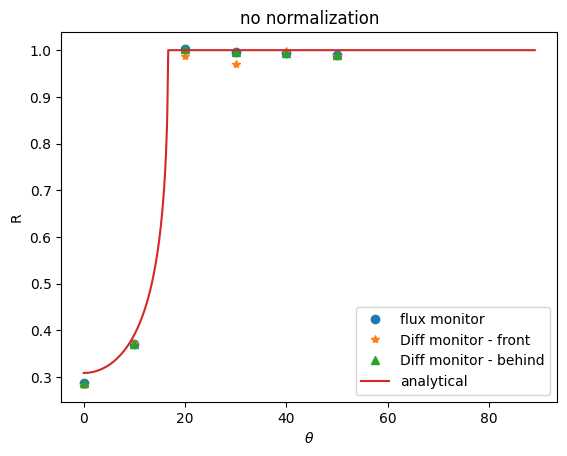

In [11]:
# %matplotlib qt
fig,ax = plt.subplots()
ax.plot(thetas,reflection,'o',label = 'flux monitor')

ax.plot(thetas,reflection_diffMon,'*', label = 'Diff monitor - front')

ax.plot(thetas,reflection_diffMon2,'^', label = 'Diff monitor - behind')

ax.plot(theta,rs,label = 'analytical')

ax.legend()

ax.set_title('no normalization')
ax.set_ylabel('R')
ax.set_xlabel('$\\theta$')

In [12]:
norm = [results_norm[i]['FT'].flux for i in results_norm.keys()]
normD= [results_norm[i]['DR'].power.sum() for i in  results_norm.keys()]
normD2= [results_norm[i]['DT'].power.sum() for i in  results_norm.keys()]

09:13:53 -03 WARNING: Simulation final field decay value of 4.96e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:13:55 -03 WARNING: Simulation final field decay value of 4.96e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

09:13:57 -03 WARNING: Simulation final field decay value of 4.96e-05 is greater 
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

In [13]:
Rflux = [reflection[i]/norm[i] for i in range(len(thetas))]
Rdiff1 = [reflection_diffMon[i]/normD2[i] for i in range(len(thetas))]
Rdiff2 = [reflection_diffMon2[i]/normD2[i] for i in range(len(thetas))]

Text(0.5, 0, '$\\theta$')

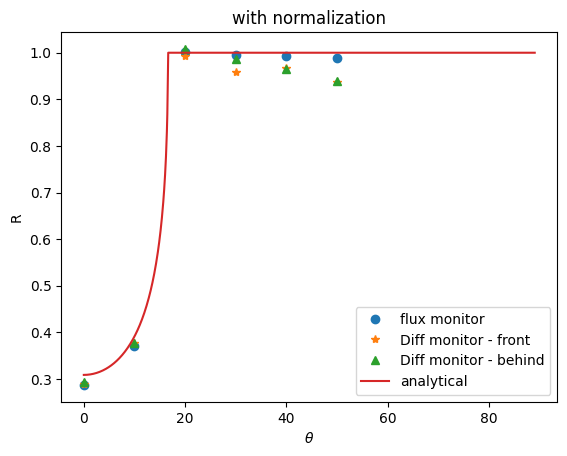

In [14]:
# %matplotlib qt
fig,ax = plt.subplots()
ax.plot(thetas,Rflux ,'o',label = 'flux monitor')

ax.plot(thetas,Rdiff1,'*', label = 'Diff monitor - front')

ax.plot(thetas,Rdiff2,'^', label = 'Diff monitor - behind')

ax.plot(theta,rs,label = 'analytical')

ax.legend()

ax.set_title('with normalization')
ax.set_ylabel('R')
ax.set_xlabel('$\\theta$')

